# Exercise 4: Extension 1

This extension examines the dependence of the error on binsize.

### Potentials

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import vegas
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

#Harmonic
def v_sho(x):
    
    return (x**2)/2

#Anharmonic
def v_aho(x):
    
    return (x ** 4)/2


### Action for One Spatial Point

In [58]:
def action(x, i, v, m, a): 
    ir = (i+1)%len(x) 
    il = (i-1)%len(x)
    return a *  v(x[i]) + (m/a) * x[i] * (x[i]-x[ir]-x[il])

### Update Function

In [59]:
def update(x, v, m, a, dx):
    #Updates Every Point Once
    accept = 0
    for i in range(len(x)):
        
        x_old = x[i]
        old_action = action(x=x, i=i, v=v, m=m, a=a)
        
        x[i] += np.random.uniform(-dx, dx)
        new_action = action(x=x, i=i, v=v, m=m, a=a)
        
        diff = old_action - new_action
        
        r = np.minimum(1.0, np.exp(diff))
    
        if r < np.random.rand():
            x[i] = x_old
        
        else:
            accept += 1
    
    return x, accept / len(x)

### Two Point Function

In [60]:
def G(x):
    #Returns Array Gn = [G1, G2,...]
    n = len(x)
    g = np.zeros(n)
    for j in range(n):
        for i in range(n):
            g[j] += (x[(i+j)%(n)]) *(x[i])
            
    return g/n

### Markov Chain Generation

In [61]:
def markov_chain(n_sites, n_configs, v, m, a, dx, n_corr):
    
    acceptance = 0
    config = np.zeros((n_sites))
    gn = []
    
    #Thermalise
    for i in range(10*n_corr):
        config = update(config, v, m, a, dx)[0]


    for i in range(n_configs*n_corr):
        config, acc = update(config, v, m, a, dx)
        acceptance += acc
        
        if i % n_corr == 0:
            gn.append(G(config))
            
    acceptance = acceptance / (n_configs*n_corr)       
    return gn, acceptance

### Error Stuff

In [62]:
def binning(g, bin_size):
    g_bin = []
    Ncf = len(g)
    for i in range(0, Ncf, bin_size):
        bin_val = np.mean(g[i:i+bin_size],0)
        g_bin.append(bin_val)
    return g_bin
        
        
def analysis_binned(n_sites, n_configs, v, m, a, dx, n_corr, harmonic=True):
    
           
    gn, acc = markov_chain(n_sites=n_sites, n_configs=n_configs, v=v, m=m, a=a, dx=dx, n_corr=n_corr)
    
    bin_size_arr = range(2, 50, 2)
    
    length = len(bin_size_arr)
    
    g_arr = np.empty((n_sites,length))
    g_arr_err = np.empty((n_sites,length))
    
    
    for i, bin_size in enumerate(bin_size_arr):
        
        binned_g = binning(g=gn, bin_size=bin_size)
        
        t = np.arange(0, n_sites * a, a)

        
        #######################################################################################################
        # Binned
        
        avg_binned = np.mean(binned_g, 0)
        err_binned = np.std(binned_g, 0)
        avg_shift_binned = np.roll(avg_binned, -1)
        err_shift_binned = np.roll(err_binned, -1)
        
        E_eff_binned = np.log(np.divide(avg_binned, avg_shift_binned)) / a
        E_eff_err_binned = np.sqrt(np.divide(err_binned, avg_binned)**2 + np.divide(err_shift_binned, avg_shift_binned)**2)/ a / np.sqrt(n_configs/bin_size)
    
        
        #######################################################################################################
        
        
        g_arr[:,i] = E_eff_binned
        g_arr_err[:,i] = E_eff_err_binned
        
    
    fig, ax =  plt.subplots(nrows=int(n_sites/4)-1, ncols=1, figsize=(12, 1.5*n_sites), dpi=100)
    fig.subplots_adjust(wspace=0.3, hspace=0.1)
    
    y_ticks = np.linspace(0, 2, 20)
    
    for j in range(int(n_sites/4)-1):
    
        
        ax[j].errorbar(bin_size_arr, g_arr[j,:], yerr=g_arr_err[j,:], fmt='o',  markersize=2, color='k')
        ax[j].set_title("Plot of t= " + str(0.5*j) + " error for increasing bin size")  
        ax[j].set_xlim(0, 50)
        ax[j].set_ylim(1, 2)
        ax[j].set_yticks(y_ticks)
        ax[j].set_yticklabels([])
        ax[j].set_axisbelow(True)
        ax[j].yaxis.grid(color='gray', linestyle='dashed')
    
        
        
    plt.show
    
    

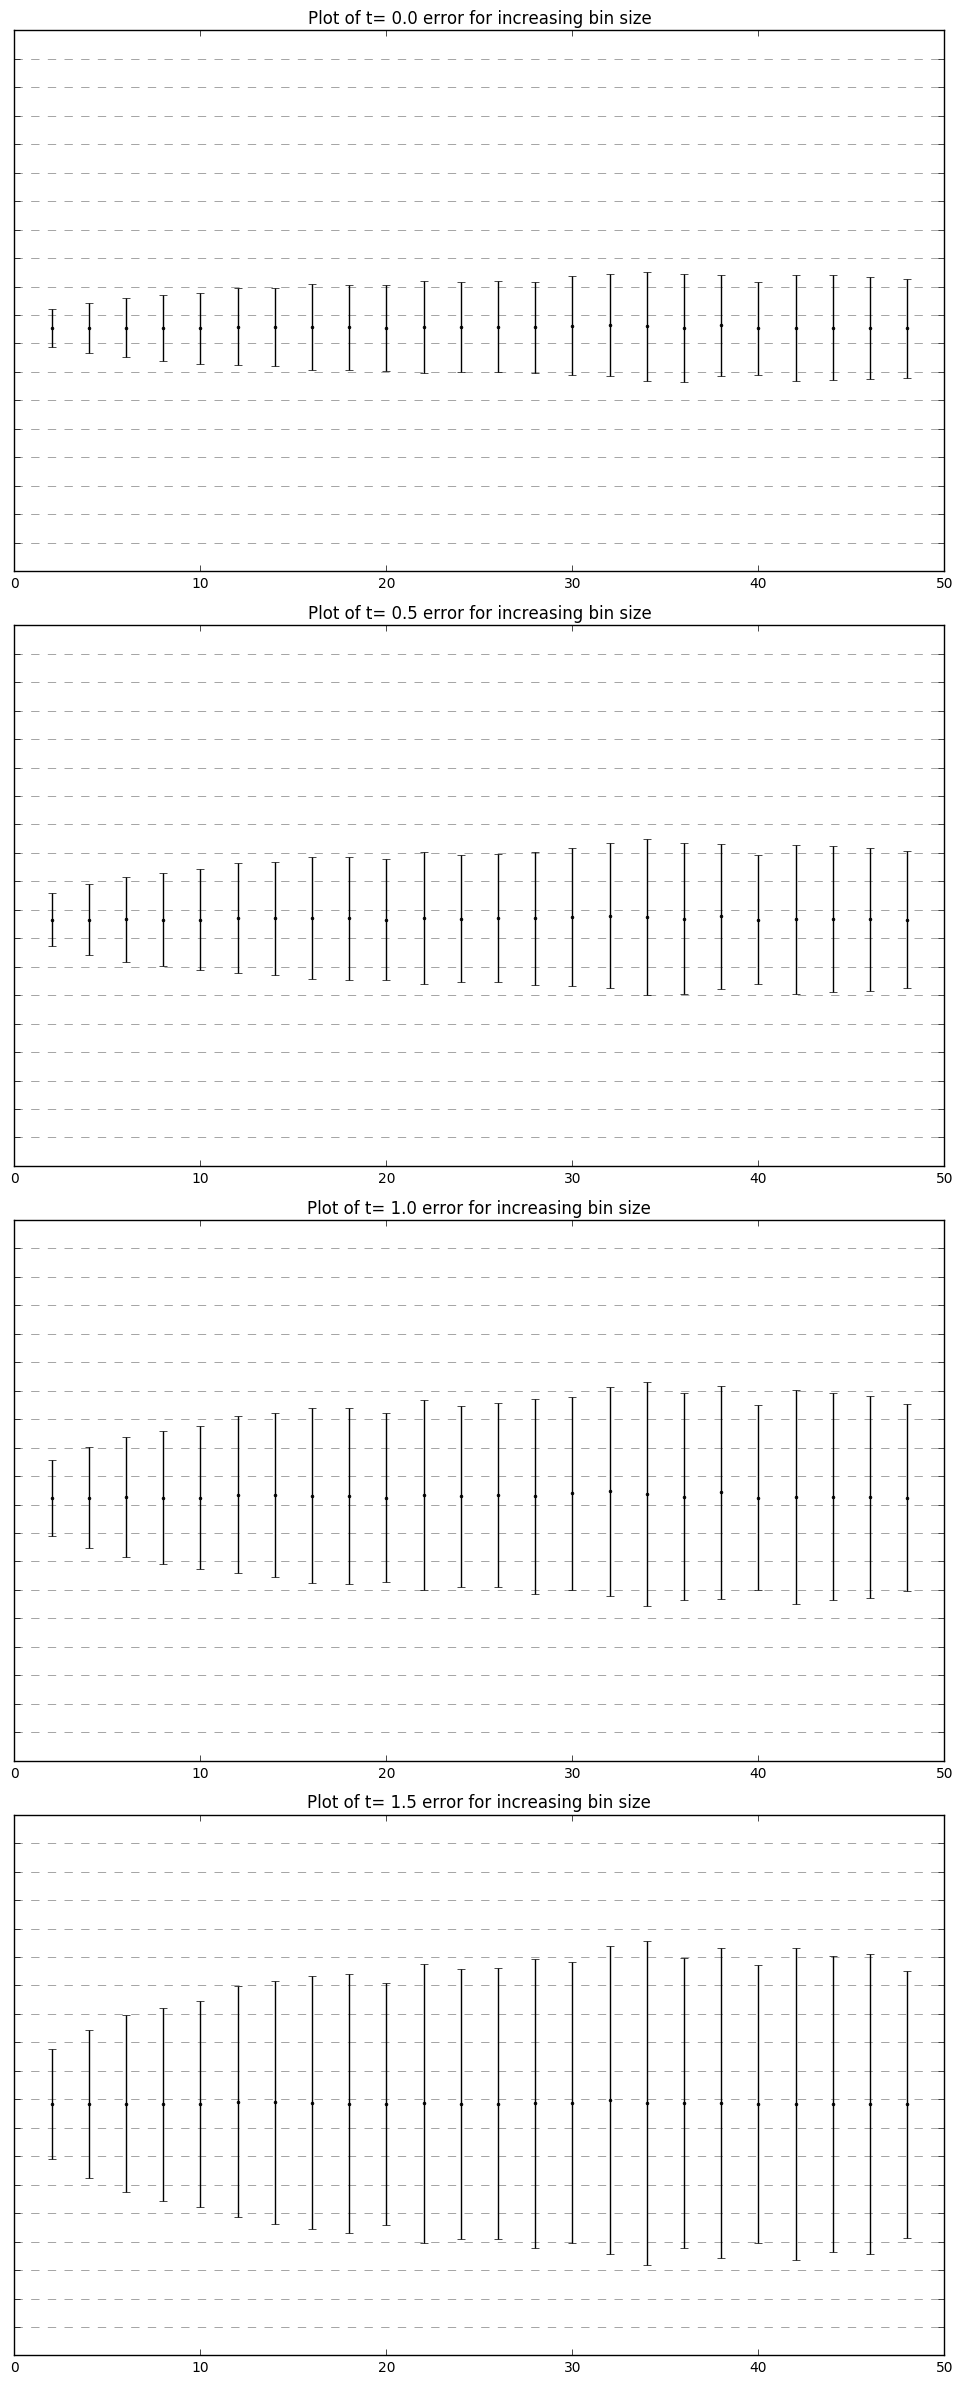

In [63]:
analysis_binned(n_sites=20, n_configs=1000, v=v_sho, m=1, a=0.5, dx=1.4, n_corr = 1)